# Comparing results from different levels of theory

This tutorial shows how to compare results from different levels of theory, including CREST, CENSO, and single-point DFT calculations on CREST geometries.

- To get started, make sure that the GEOM repo is in your path
- You'll also need to install the [Neural Force Field repository](https://github.com/learningmatter-mit/NeuralForceField) and put it in your path. We'll be using it to rapidly compare distances between conformers using batching with PyTorch

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Change to your path for the GEOM repo 

import sys
sys.path.insert(0, '/home/saxelrod/Repo/projects/geom')

# Change to your Neural Force Field path

sys.path.insert(0, '/home/saxelrod/Repo/projects/master/NeuralForceField')



### Loading the CREST and CENSO data

In [3]:
from utils.compare import (load_pickle, 
                           get_all_distances, 
                           plot_geometry_changes, 
                           get_crest_censo_en_changes,
                           plot_en_changes,
                           plot_free_en_comparison,
                           get_censo_sp_en_changes,
                           plot_crest_vs_sp)
import os

In [4]:
# change to your folders for the saved conformer data

base_dir = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews/export'
crest_dir = os.path.join(base_dir, 'bace_water/rd_mols')
censo_dir = os.path.join(base_dir, 'censo/rd_mols')

Load the conformer information for both CREST and CENSO:

In [5]:
censo_dict = load_pickle(censo_dir)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 534/534 [00:06<00:00, 77.00it/s]


In [6]:
crest_dict = load_pickle(crest_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1511/1511 [18:29<00:00,  1.36it/s]


# Single-point calculations
### Getting acquainted with the data

All of the CREST conformers also have single-point DFT calculations with the r2scan-3c functional, without optimization. To get the single-point calculations, we simply have to use the key `r2scan_3c_mtzvpp`:

In [9]:
r2scan_key = 'r2scan_3c_mtzvpp'

count_dic = {}

for smiles, confs in crest_dict.items():
    this_count = {"r2scan_count": len([conf for conf in confs if r2scan_key in conf]),
                  "total_confs": len(confs)}
    count_dic[smiles] = this_count

r2scan_count = sum([val['r2scan_count'] for val in count_dic.values()])
total_confs = sum([val['total_confs'] for val in count_dic.values()])

r2scan_pct = r2scan_count / total_confs * 100
num_missing = total_confs - r2scan_count

pct_list = [val['r2scan_count'] / val['total_confs'] * 100 for val in count_dic.values()]
lowest_3 = sorted(pct_list)[:3]
lowest_3_str = "%, ".join(['%.2f' % i for i in lowest_3])

print(f"{total_confs:,} conformers in total")
print(f"{r2scan_pct:.2f}% of all conformers have r2scan-3c calculations")
print(f"Number of conformers missing DFT calculations: {num_missing}")

1,314,217 conformers in total
100.00% of all conformers have r2scan-3c calculations
Number of conformers missing DFT calculations: 0


As promised, all conformers have r2scan-3c calculations!

## Comparing CREST and r2scan-3c single-point conformer energies
Now that we've seen how to analyze some of the data, let's compare relative energies computed with r2scan-3c and xTB (through CREST):

Cutoff for ensemble completeness: 1.00
MAE: 1.96 kcal/mol
R^2: -1.89


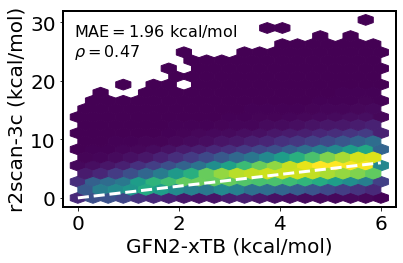

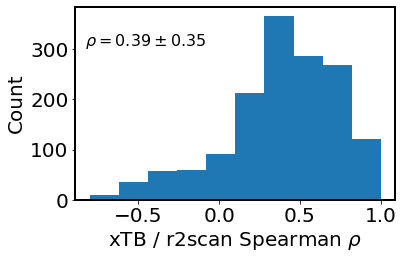

In [10]:
save_dir = '/home/saxelrod/plots'

plot_crest_vs_sp(crest_dict=crest_dict,
                 sp_key=r2scan_key,
                 save_dir=save_dir,
                 cutoffs=[1.00] # 100% of conformers in an ensemble need DFT calculations
                                # for it to be included in the comparison
                )

We see that the average error of xTB (CREST) with respect to r2scan-3c is 1.96 kcal/mol, which is similar to benchmarks of xTB for conformational energies. There is moderate correlation between the ranking of conformers with CREST and with r2scan-3c (Spearman $\rho = 0.39$).

## CENSO Geometry changes
Here we'll look at changes in conformer geometries when going from CREST to CENSO. We'll do this in two ways. The first way is just to look at the CREST conformer that was optimized, and see how much the geometry changed with CENSO. The second is to find the closest CREST conformer to each CENSO conformer, and then see how different they are. The second approach requires a lot of distance calculations, and so it's a bit slow.

In [11]:
out = get_all_distances(crest_dict,
                        censo_dict)

# `output_dic` contains distance information, while the last two outputs
# provide the index mapping between censo conformers and their seed conformers
# in crest (`censo_to_seed_crest`), or censo conformers and the closest
# conformer in crest (`censo_to_closest_crest`)

output_dic, censo_to_seed_crest, censo_to_closest_crest = out

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 534/534 [03:35<00:00,  2.48it/s]


CENSO vs. CREST geometries,
 relative to seed CREST conf


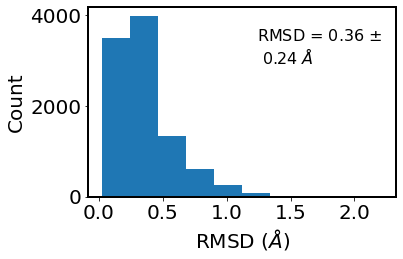

CENSO vs. CREST geometries,
 relative to closest CREST conf


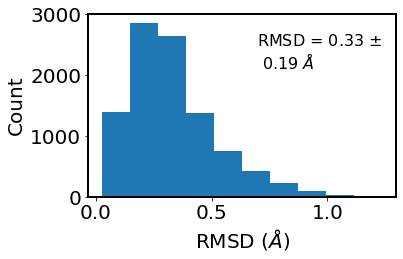

In [12]:
save_dir = '/home/saxelrod/plots'

plot_geometry_changes(output_dic,
                      save_dir=save_dir,
                      save_name="geom_compare.png")

We see that the geometry changes after optimization are quite small. Whether you're looking at how much the starting conformer changes, or how different the final CENSO conformer is from the most similar CREST conformer, the RMSD is around 0.35 Angstrom. In the former case, no RMSD is above 2 Angstrom, and in the latter case, none is above about 1 Angstrom.

## CENSO vs. single-point energies
Now let's see how much the r2scan-3c energies change after a conformer is optimized:

In [ ]:
censo_sp_dic = get_censo_sp_en_changes(censo_dict,
                                       crest_dict,
                                       censo_to_seed_crest,
                                       censo_to_closest_crest,
                                       sp_key='r2scan_3c_mtzvpp')

In [ ]:
for name, dic in censo_sp_dic.items():
    
    print(name)

    sub_dics = dic.values()
    rhos = np.array([i['spearman'] for i in sub_dics])
    rhos = rhos[np.isfinite(rhos)]
    mean = np.mean(rhos)
    std = np.std(rhos)
    text = r"$\rho = %.2f \pm %.2f$" % (mean, std)
    
    fig, ax = plt.subplots()
    plt.hist(rhos)
    plt.text(0.03, 0.8, text, 
            transform=ax.transAxes,
            fontsize=16)
    [i.set_linewidth(2) for i in ax.spines.values()]
    plt.xlabel(r"SP / CENSO Spearman $\rho$")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'rho_censo_sp_{name}.png'),
                dpi=300)
    plt.show()

## CENSO vs. CREST

Lastly, we can ask how correlated the CREST rankings are with the CENSO rankings. The results have to be interpreted with caution, however, because only the true low-energy conformers are in the CENSO ensembles. So we ignore the high-energy ones that CREST may have gotten wrong. That means the Spearman coefficient is very likely an overestimate.

In [ ]:
en_results = get_crest_censo_en_changes(censo_dict,
                                        crest_dict,
                                        censo_to_seed_crest,
                                        censo_to_closest_crest)
plot_en_changes(en_results,
                save_dir=save_dir,
                save_name='en_change.png')


## Energy vs. free energy
Lastly, let's compare the orderings based on CENSO energies to those based on CENSO free energies (which incorporate translational, rotational, and vibrational entropy, plus zero-point vibrational corrections).

In [ ]:
plot_free_en_comparison(censo_dict,
                        save_dir=save_dir,
                        save_name='rrho_contrib.png')

We see that the rankings by CENSO energy are quite well-correlated with the rankings by free energy.